In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1,L2

# import wandb
# from wandb import WandbCallback


In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy","sad" ]


CONFIGURATION = {
   "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "BATCH_SIZE": 32,
    "DROPOUT_RATE": 0.2,
    "IM_SIZE": 600,
    "REGULARIZATION_RATE": 0.2,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3

}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory ,
    labels = "inferred",
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
     batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99,


)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory ,
    labels = "inferred",
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99


)

Found 2278 files belonging to 3 classes.


In [ ]:
import tensorflow as tf

# Assuming you have defined `train_dataset` and `augment_layer` function

# Apply data augmentation to the training dataset
training_dataset = (
    train_dataset
    # .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

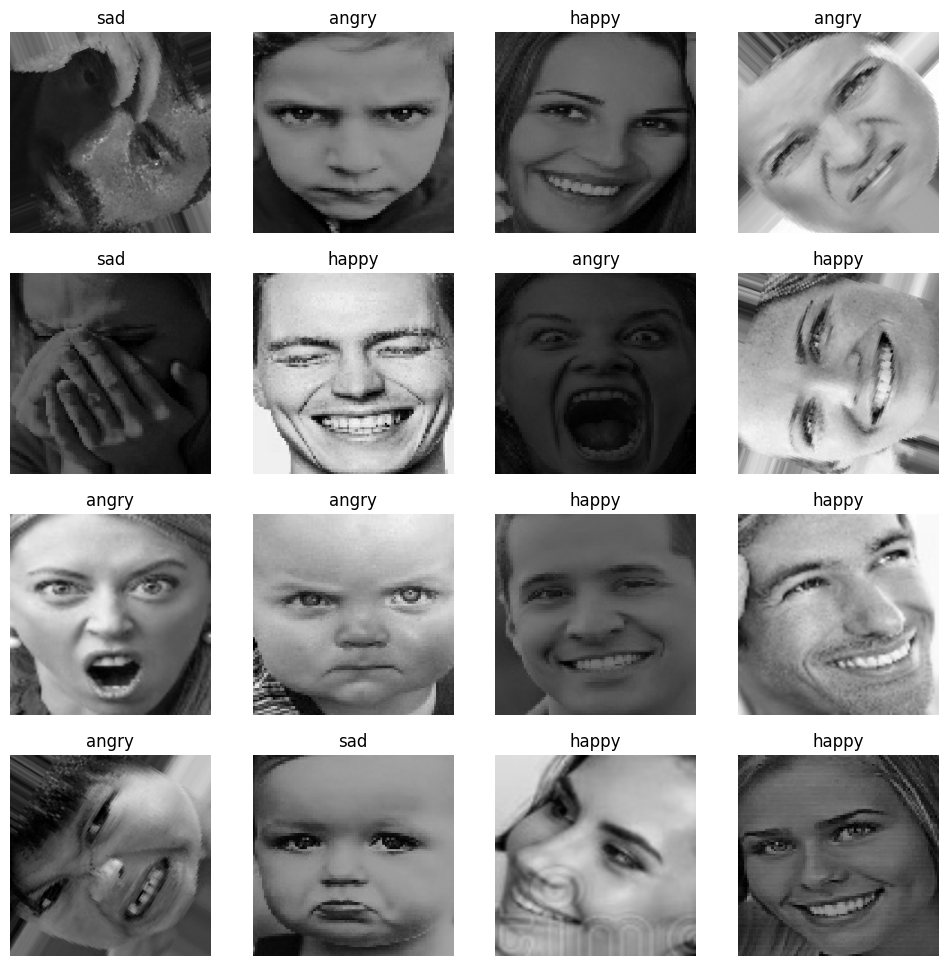

In [ ]:
plt.figure(figsize =(12,12))

for images, label in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(label[i], axis =0).numpy()])
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.4),
  layers.RandomZoom(0.4),
  layers.RandomHeight(0.4),
  layers.RandomWidth(0.4),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")


In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top =False,
    weights = 'imagenet',
    input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)

71686520/71686520 [==============================] - 4s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    data_augmentation,
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu'),
    Dropout(CONFIGURATION['DROPOUT_RATE']),
    Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')])

In [ ]:
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb4 (Functional  (None, 19, 19, 1792)      17673823  
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_3 (Bat  (None, 1024)              4096      
 chNormalization)                                     

In [ ]:
pretrained_model.compile(
    loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate =  0.001),
              metrics=["accuracy"])

In [ ]:
# Fit the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


history  = pretrained_model.fit(training_dataset,
                    epochs=5,
                    # steps_per_epoch=len(training_dataset),
                    validation_data=validation_dataset,
                    # validation_steps=int(0.25* len(validation_dataset)), # validate for less steps
                    # Track model training logs
                    callbacks=[  early_stopping],
                                verbose =1 )

Epoch 1/5
213/213 [==============================] - 458s 2s/step - loss: 1.2717 - accuracy: 0.5067 - val_loss: 0.9084 - val_accuracy: 0.6093
Epoch 2/5
213/213 [==============================] - 400s 2s/step - loss: 0.9511 - accuracy: 0.5785 - val_loss: 0.7790 - val_accuracy: 0.6651
Epoch 3/5
213/213 [==============================] - 385s 2s/step - loss: 0.8503 - accuracy: 0.6155 - val_loss: 0.8153 - val_accuracy: 0.6541
Epoch 4/5
213/213 [==============================] - 390s 2s/step - loss: 0.8266 - accuracy: 0.6248 - val_loss: 0.7210 - val_accuracy: 0.6861
Epoch 5/5
213/213 [==============================] - 397s 2s/step - loss: 0.7900 - accuracy: 0.6469 - val_loss: 0.8106 - val_accuracy: 0.6475


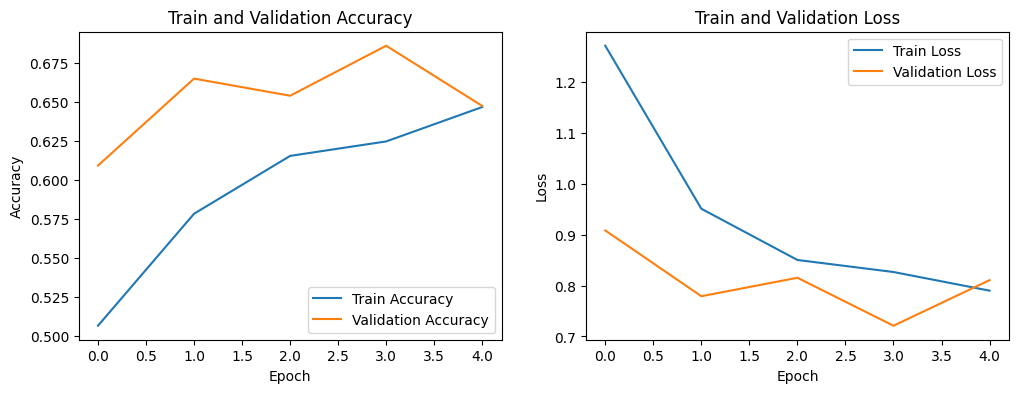

In [ ]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

resnet = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:


# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
history1 = resnet.fit(
    training_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
213/213 [==============================] - 119s 388ms/step - loss: 0.9308 - accuracy: 0.5930 - val_loss: 3.0551 - val_accuracy: 0.5584
Epoch 2/10
213/213 [==============================] - 75s 352ms/step - loss: 0.5993 - accuracy: 0.7464 - val_loss: 0.7575 - val_accuracy: 0.6817
Epoch 3/10
213/213 [==============================] - 76s 358ms/step - loss: 0.5039 - accuracy: 0.7910 - val_loss: 0.6310 - val_accuracy: 0.7739
Epoch 4/10
213/213 [==============================] - 76s 354ms/step - loss: 0.4274 - accuracy: 0.8267 - val_loss: 1.1075 - val_accuracy: 0.7076
Epoch 5/10
213/213 [==============================] - 76s 354ms/step - loss: 0.3741 - accuracy: 0.8501 - val_loss: 0.6915 - val_accuracy: 0.7410
Epoch 6/10
213/213 [==============================] - 77s 359ms/step - loss: 0.3116 - accuracy: 0.8792 - val_loss: 1.0707 - val_accuracy: 0.6997
Epoch 7/10
213/213 [==============================] - 77s 361ms/step - loss: 0.2748 - accuracy: 0.8992 - val_loss: 0.7802 - val_a

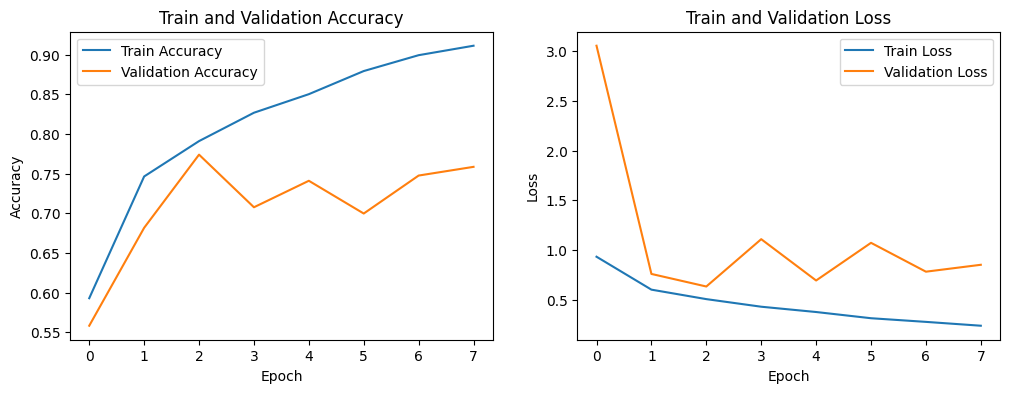

In [ ]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.show()

# Evaluation

In [ ]:
resnet.evaluate(validation_dataset)

72/72 [==============================] - 7s 96ms/step - loss: 0.8496 - accuracy: 0.7586


[0.849645733833313, 0.7585601210594177]

In [ ]:
pretrained_model.evaluate(validation_dataset)

72/72 [==============================] - 18s 163ms/step - loss: 0.7386 - accuracy: 0.6910


[0.7385830879211426, 0.6909569501876831]

# Ensembling

In [ ]:

CONFIGURATION = {
   "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "BATCH_SIZE": 32,
    "DROPOUT_RATE": 0.2,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.2,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3

}

In [ ]:
inputs = Input(shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))

y1 = resnet(inputs)
y2 = pretrained_model(inputs)

outputs = 0.5*y1+0.5*y2

ensemble_model = Model(
    inputs = inputs,
    outputs =outputs
)

In [ ]:
ensemble_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_6 (Functional)        (None, 3)                    2568896   ['input_15[0][0]']            
                                                          3                                       
                                                                                                  
 sequential_1 (Sequential)   (None, 3)                    1964553   ['input_15[0][0]']            
                                                          8                                       
                                                                                            

In [ ]:
ensemble_model.compile(
    loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate =  0.001),
              metrics=["accuracy"])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Resizing, Input

# Define the input layer with resizing
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)
x = Resizing(600, 600)(inputs)

# Load the base model with the resized input
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

# Add the new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

ensemble_model = Model(inputs=inputs, outputs=predictions)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
history2 = ensemble_model.fit(
    training_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node model_8/conv3_block3_3_conv/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-90-cc420ebad099>", line 29, in <cell line: 29>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[32,512,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_8/conv3_block3_3_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_147265]

Number is 
